## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [229]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /Users/I331963/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [145]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [146]:
# Inspect the dataframe to understand the given data.

df.shape

(78313, 22)

Provided JSON file consists of 78313 different cases and 22 columns

In [147]:
# Get information about columns and corresponding missing/null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [148]:
#Printing sample data
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Customer complaints are mentioned in columns '_source.complaint_what_happened' and associated tags are present in column '_source.product' 

In [149]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [150]:
#Assign new column names
#Remove _ and source from column names
columns_updated = [re.sub('^_','',column) for column in df.columns]
columns_updated = [re.sub('^source\.','',column) for column in columns_updated]
df.columns = columns_updated
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [151]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("",np.nan,inplace=True)

In [152]:
#Check for percentage of nan in complaint_what_happened colummn
df['complaint_what_happened'].isnull().sum()/len(df)

0.7309258999144459

In [153]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])
#Print the length of cleaned data
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [154]:
# Write your function here to clean the text and remove all the unnecessary elements.
def data_cleaning(text):
    
    #Convert text to lower case
    text = text.lower()
    
    #Remove text in square brackets
    text = re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b','',text)
    
    return text

In [155]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda text: data_cleaning(text))

In [156]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Lemmatize each word and join them back into a string
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words into a string
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

In [157]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['complaint_lemmatized'] = df['complaint_what_happened'].apply(lambda text: lemmatize_text(text))

df_clean = df[['complaint_what_happened','complaint_lemmatized']]

In [158]:
# Environment settings to print more content: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)
df_clean.head()

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check wa clear money wa taking by my chase bank refuse to pay me my money my grand son called chase time they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [159]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

In [161]:
#Write your function to extract the POS tags 
def pos_tag(text):
    # Process the text with spaCy
    doc = nlp(text)
    nn_words = []
    for tok in doc:
        if(tok.tag_== 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

In [162]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_NN_removed"] =  df_clean['complaint_lemmatized'].apply(lambda text: pos_tag(text)) 

In [163]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,xxxx ticket offer ticket reward card information offer minute screen decision bank chase bank notification screen representative application information xxxx offer credit offer account statement ticket account application representative application request application representative chase fact credit account name credit report chase information credit report application error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clea

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




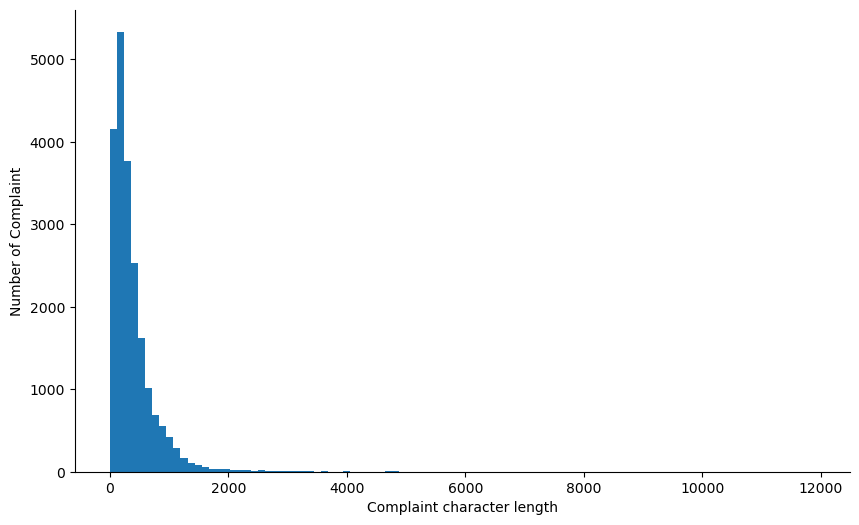

In [164]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_NN_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

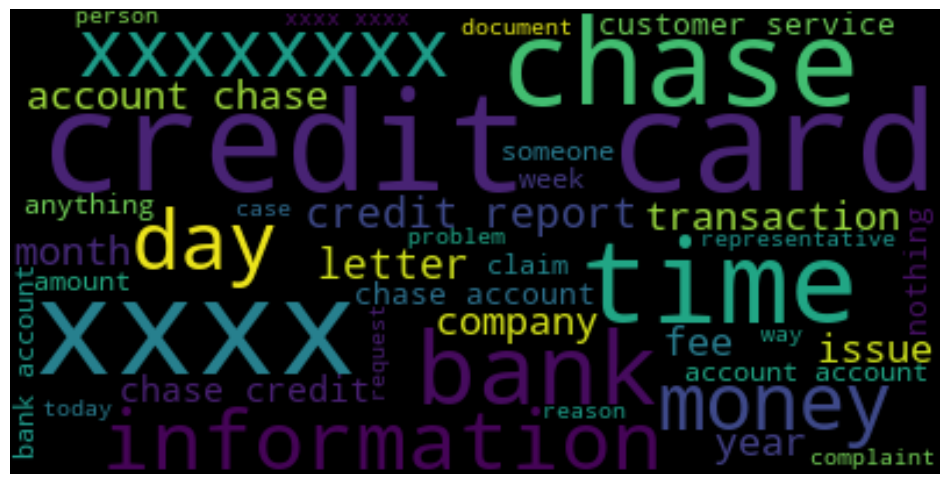

In [165]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_NN_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [166]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_NN_removed'].str.replace('-PRON-', '')

In [167]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,xxxx ticket offer ticket reward card information offer minute screen decision bank chase bank notification screen representative application information xxxx offer credit offer account statement ticket account application representative application req

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [168]:
#Generic function to get the top n grams
def get_top_n_gram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [169]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_unigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=1, top=30)

In [170]:
#Print the top 10 words in the unigram frequency
print('Top 10 Unigrams:\n')
top_30_unigrams[:10]

Top 10 Unigrams:



[('chase', 51397),
 ('account', 46341),
 ('xxxx', 33355),
 ('credit', 32553),
 ('card', 30105),
 ('payment', 21156),
 ('bank', 20742),
 ('time', 16027),
 ('day', 12961),
 ('money', 11954)]

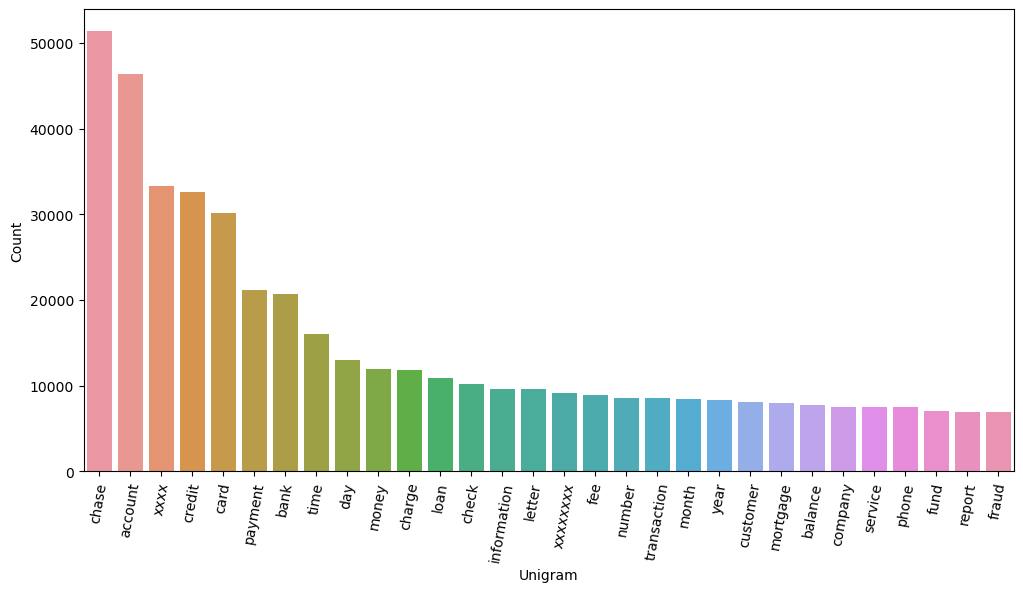

In [171]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['Unigram' , 'Count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['Unigram'], y=df1['Count'])
plt.xticks(rotation = 80)
plt.show()

In [172]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=2, top=30)

In [173]:
#Print the top 10 words in the bigram frequency
print('Top 10 Bigrams:\n')
top_30_bigrams[:10]

Top 10 Bigrams:



[('credit card', 12833),
 ('credit report', 3843),
 ('account chase', 3144),
 ('customer service', 3057),
 ('chase account', 2913),
 ('chase credit', 2911),
 ('account account', 2681),
 ('bank account', 2516),
 ('xxxx xxxx', 2392),
 ('chase bank', 2069)]

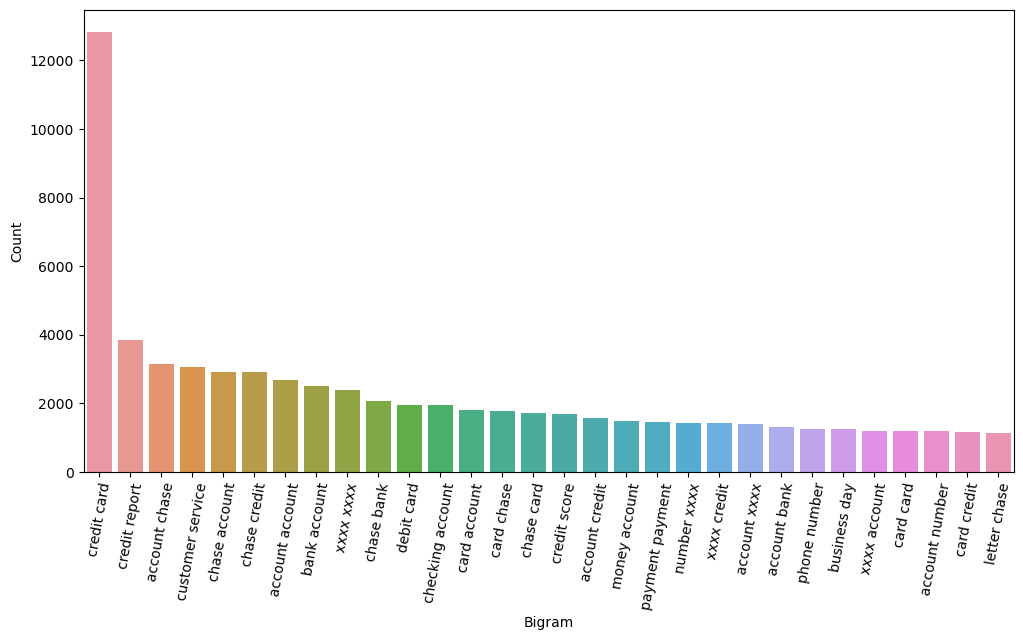

In [174]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['Bigram' , 'Count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['Bigram'], y=df2['Count'])
plt.xticks(rotation = 80)
plt.show()

In [175]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=3, top=30)

In [176]:
#Print the top 10 words in the trigram frequency
print('Top 10 Trigrams:\n')
top_30_trigrams[:10]

Top 10 Trigrams:



[('chase credit card', 1932),
 ('credit card account', 1128),
 ('credit card company', 997),
 ('credit card chase', 784),
 ('xxxx credit card', 731),
 ('credit card credit', 561),
 ('inquiry credit report', 513),
 ('card credit card', 446),
 ('account credit card', 445),
 ('credit reporting agency', 384)]

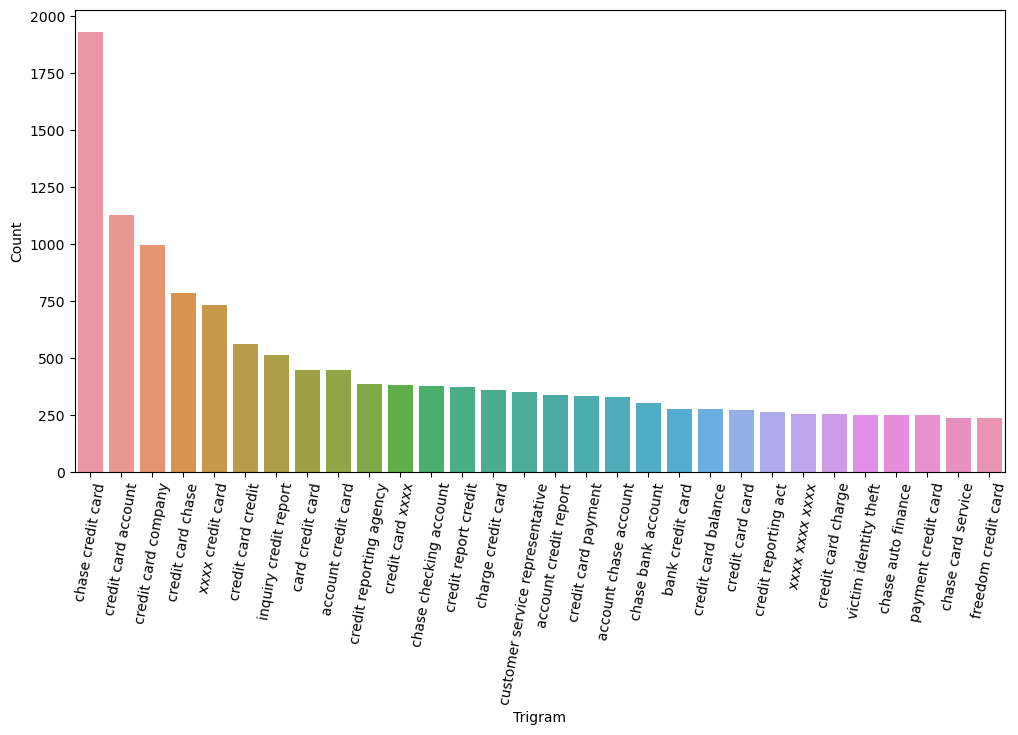

In [177]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['Trigram' , 'Count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['Trigram'], y=df3['Count'])
plt.xticks(rotation = 80)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [178]:
df_clean['complaint_POS_N_removed'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [179]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean,complaint_POS_N_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [208]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [209]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [210]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [211]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [212]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

101

In [213]:
W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [214]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [215]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.06,0.02,0.08,0.19,0.02,3
Doc1,0.23,0.04,0.00,0.00,0.00,0
Doc2,0.00,0.59,0.00,0.00,0.00,1
Doc3,0.12,0.53,0.00,0.03,0.00,1
Doc4,0.14,0.00,0.00,0.53,0.00,3


In [216]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = significant_topic

In [217]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean,complaint_POS_N_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,agent anniversary date agent information order account anniversary date consent recording agent,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on th

In [218]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean,complaint_POS_N_removed,Topic
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,agent anniversary date agent information order account anniversary date consent recording agent,0
48,jp morgan chase bank please answer the following questions on xxxxxxxx xxxxxxxxxxxxxxxx xxxxxxxx xxxxxxxx jpmorgan chase accessed information about me through xxxx xxxx xxxx xxxx \nwhat was the valid reason for accessing my personal information through xxxx xxxx xxxx xxxx \n\n the chase checking account that was closed recently during xxxxxxxx had a routing or xxxx number of xxxx according to checks and statements provided to me by chase \nxxxx xxxx xxxx showed chase reporting an xxxx...,jp morgan chase bank please answer the following question on xxxxxxxx xxxxxxxxxxxxxxxx xxxxxxxx xxxxxxxx jpmorgan chase accessed information about me through xxxx xxxx xxxx xxxx what wa the valid reason for accessing my personal information through xxxx xxxx xxxx xxxx the chase checking account that wa closed recently during xxxxxxxx had a routing or xxxx number of xxxx according to check and statement provided to me by chase xxxx xxxx xxxx showed chase reporting an xxxx routing number of xx...,question information reason information chase account routing xxxx number statement chase xxxx number xxxx xxxx number chase number xxxxxxxx response dispute information chase report dispute case xxxx information chase info question cfpb copy information question complaint mail xxxx attention response,question information reason information chase account routing xxxx number statement chase xxxx number xxxx xxxx number chase number xxxxxxxx response dispute information chase report dispute case xxxx information chase info question cfpb copy information question complaint mail xxxx attention response,question information reason information chase account routing number statement chase number number chase number response dispute information chase report dispute case information chase info question cfpb copy information question complaint mail attention response,0
32,my chase amazon card was declined for a catering order i had placed for my brothers funeral in the amount of i contacted chase around noon today and was asked the last numbers of my chase savings account and the other user on my account i responded that i did not have a savings and i am only authorized user customer rep told me they would call me back in minutes to keep the line open i didnt receive a call back after an hour so i contacted chase from the first call i thought someone was ...,my chase amazon card wa declined for a catering order i had placed for my brother funeral in the amount of i contacted chase around noon today and wa asked the last number of my chase saving account and the other user on my account i responded that i did not have a saving and i am only authorized user customer rep told me they would call me back in minute to keep the line open i didnt receive a call back after an hour so i contacted chase from the first call i thought someone wa using my car...,chase catering order brother funeral a

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [219]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Theft/Dispute Reporting',
    3: 'Mortgage/Loan',
    4: 'Others'  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [220]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean,complaint_POS_N_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,agent anniversary date agent information order account anniversary date consent recording agent,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [221]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
    'Bank Account services': 0,
    'Credit card or prepaid card': 1,
    'Theft/Dispute Reporting': 2,
    'Mortgage/Loan': 3,
    'Others': 4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [222]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_NN_removed,Complaint_clean,complaint_POS_N_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,xxxx agent anniversary date agent information order account anniversary date consent xxxx recording agent,agent anniversary date agent information order account anniversary date consent recording agent,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on th

In [224]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean.drop(['complaint_lemmatized', 'complaint_POS_NN_removed', 'Complaint_clean', 'complaint_POS_N_removed'], axis=1)

In [225]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,3
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,3
15,can you please remove inquiry,4
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an a...,3
20,during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed...,2
21,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at...,0
23,i have a chase credit card which is incorrectly reporting data on my credit report the company is not helping resolve the issue,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [226]:
X = training_data.complaint_what_happened
y = training_data.Topic

In [230]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [231]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [232]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [272]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [234]:
#Helper function to display the model summary
def display_classification_summary(model,metric):
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Summary for Train:\n',model_report_train)
    print('Classification Summary for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

### 1. Multinomial Naive Bayes

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.75
Train Accuracy : 0.87
Test Accuracy : 0.2
Classification Summary for Train:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.72      0.70      0.69        15
weighted avg       0.83      0.87      0.83        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy            

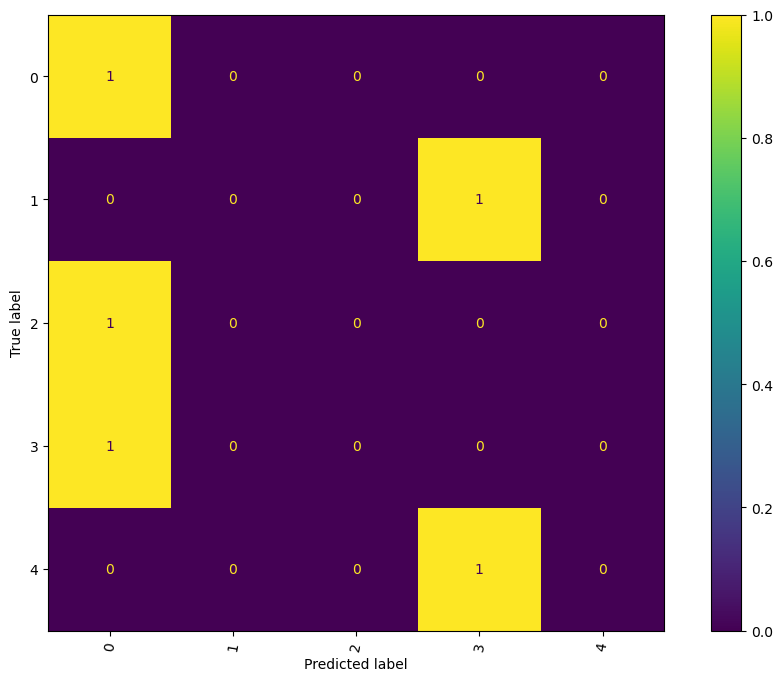

In [241]:
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_summary(mnb,metric1)

### 2. Logistic Regression

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.8
Train Accuracy : 0.93
Test Accuracy : 0.2
Classification Summary for Train:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           0.93        15
   macro avg       0.96      0.90      0.91        15
weighted avg       0.95      0.93      0.93        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy             

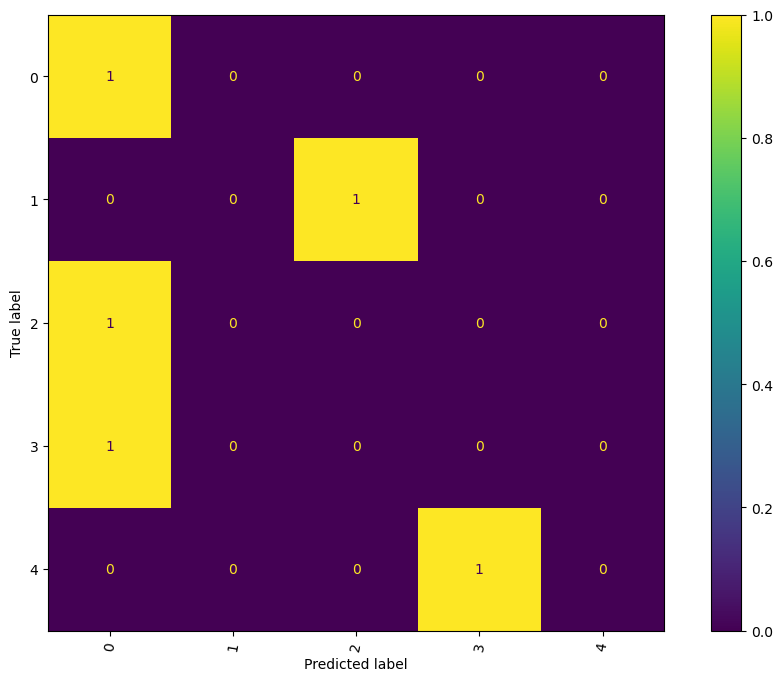

In [266]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_summary(log_reg,metric2)

### 3. Decision Tree

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.38
Train Accuracy : 1.0
Test Accuracy : 0.0
Classification Summary for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0

    accuracy             

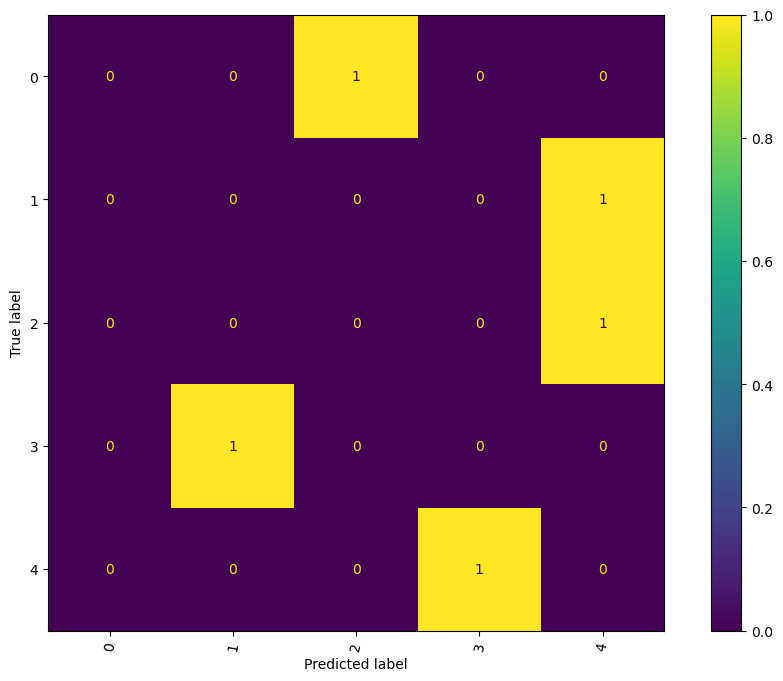

In [243]:
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_summary(dtc,metric3)

### 4. Random Forest

OOB SCORE : 0.13333333333333333
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.7
Train Accuracy : 1.0
Test Accuracy : 0.4
Classification Summary for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00      

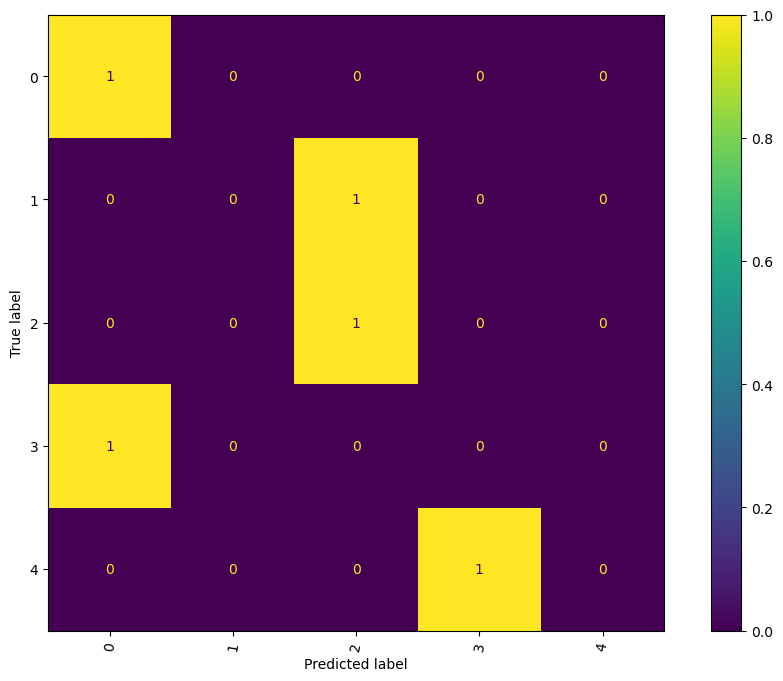

In [244]:
rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_summary(rf,metric4)

## Hyper parameter tuning with GridSearchCV

In [253]:
#Create 5 folds
folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 40)

In [254]:
#Utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [255]:
#Utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

### 1. Multinomial Naive Bayes

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Score:  0.35416666666666663
Best Hyperparameters:  {'alpha': 1}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.75
Train Accuracy : 0.87
Test Accuracy : 0.2
Classification Summary for Train:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.72      0.70      0.69        15
weighted avg       0.83      0.87      0.83        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
    

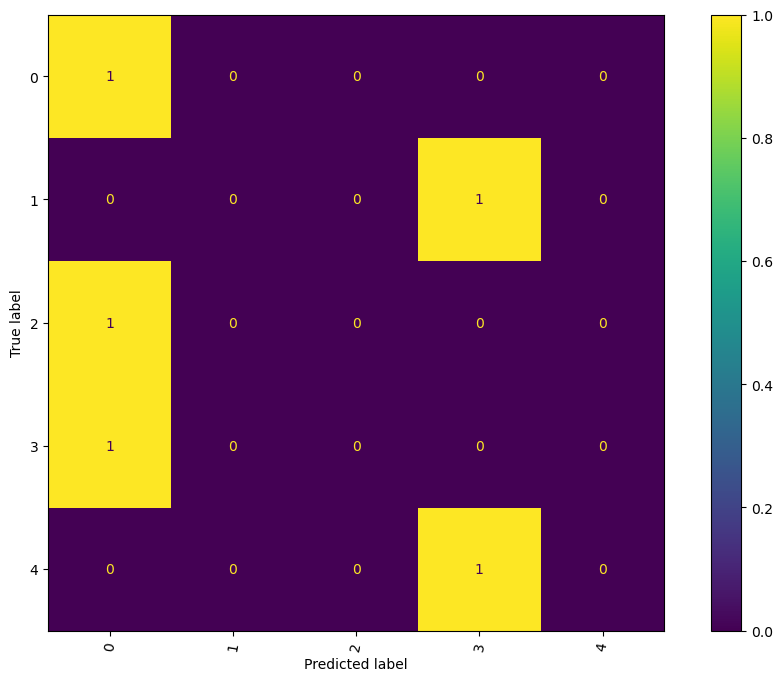

In [256]:
mnb = MultinomialNB()

mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# summary
metric5=[]
display_classification_summary(grid_search_mnb,metric5)

### 2. Logistic Regression

Fitting 4 folds for each of 18 candidates, totalling 72 fits


/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I331963/opt/anaconda3/lib/python3

Best Score:  0.3958333333333333
Best Hyperparameters:  {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.9
Train Accuracy : 1.0
Test Accuracy : 0.4
Classification Summary for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0

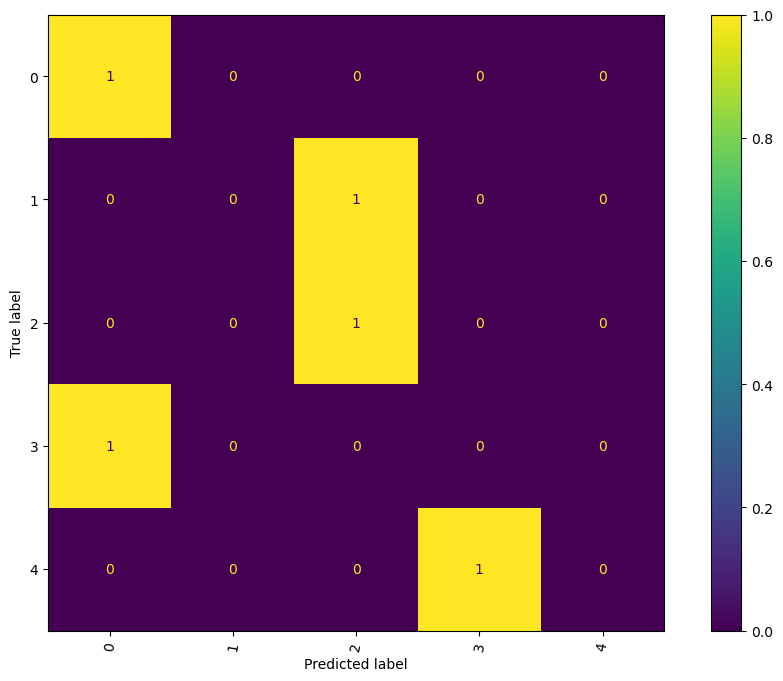

In [257]:
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# summary
metric6=[]
display_classification_summary(grid_search_log,metric6)

### 3. Decision Tree

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best Score:  nan
Best Hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 5}
ROC AUC Score Train: 0.91
ROC AUC Score Test: 0.5
Train Accuracy : 0.8
Test Accuracy : 0.4
Classification Summary for Train:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         2
           2       0.80      1.00      0.89         4
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1

    accuracy                           0.80        15
   macro avg       0.48      0.60      0.53        15
weighted avg       0.64      0.80      0.71        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50    

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

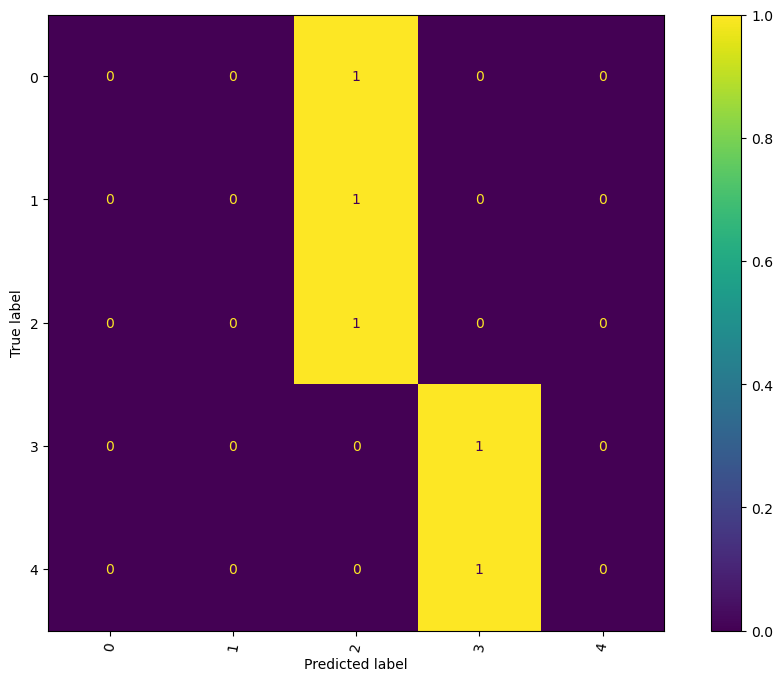

In [259]:
dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# summary
metric7=[]
display_classification_summary(grid_search_dtc,metric7)

### 4. Random Forest

Fitting 4 folds for each of 80 candidates, totalling 320 fits


/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/I331963/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/I331963/opt/anac

OOB SCORE : 0.0
Best Score:  nan
Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.35
Train Accuracy : 0.67
Test Accuracy : 0.2
Classification Summary for Train:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.00      0.00      0.00         2
           2       0.67      1.00      0.80         4
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         1

    accuracy                           0.67        15
   macro avg       0.45      0.50      0.44        15
weighted avg       0.60      0.67      0.59        15

Classification Summary for Test:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3  

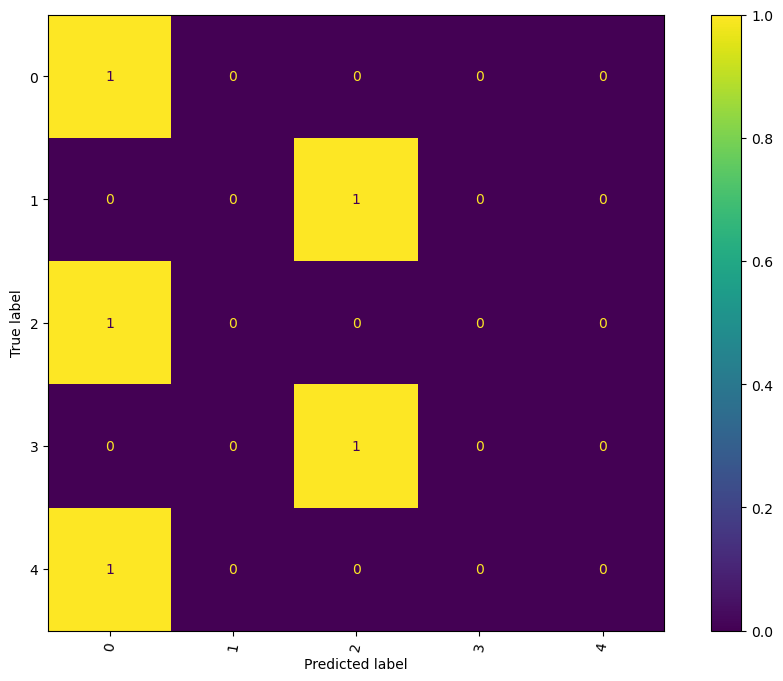

In [283]:
rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# summary
metric8=[]
display_classification_summary(grid_search_rfc,metric8)

In [284]:
# Summary of all the models
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ], 
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')
grid_mnb_metric = pd.Series(metric5, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric7, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric8, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric,
                         grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)

final_metric

,Metric,Multinomial Naive Bayes,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes with GridSearchCV,Logistic Regression with GridSearchCV,Decision Tree Classifier with GridSearchCV,Random Forest Classifier with GridSearchCV
0,ROC_AUC Score(Train),1.00,1.00,1.00,1.00,1.00,1.00,0.91,0.98
1,ROC_AUC Score(Test),0.75,0.80,0.38,0.70,0.75,0.90,0.50,0.35
2,Accuracy(Train),0.87,0.93,1.00,1.00,0.87,1.00,0.80,0.67
3,Accuracy(Test),0.20,0.20,0.00,0.40,0.20,0.40,0.40,0.20
4,Precision(Train),0.83,0.95,1.00,1.00,0.83,1.00,0.64,0.60
5,Precision(Test),0.07,0.07,0.00,0.20,0.07,0.20,0.17,0.07
6,Recall(Train),0.87,0.93,1.00,1.00,0.87,1.00,0.80,0.67
7,Recall(Test),0.20,0.20,0.00,0.40,0.20,0.40,0.40,0.20
8,F1-Score(Train),0.83,0.93,1.00,1.00,0.83,1.00,0.71,0.59
9,F1-Score(Test),0.10,0.10,0.00,0.27,0.10,0.27,0.23,0.10


In [285]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [290]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = log_reg.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [291]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Account Services
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Credit card or prepaid card
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Credit card or prepaid card
4,What is the procedure to know my CIBIL score?,Credit card or prepaid card
5,I need to know the number of bank branches and their locations in the city of Dubai,Account Services
